#  Softmax vs Argmax vs Gumbel-Softmax
Questo notebook mostra in modo interattivo le differenze tra **softmax**, **argmax** e **gumbel_softmax** 
con esempi pratici e visualizzazioni.

 Obiettivo: comprendere come si comportano questi metodi di selezione e come variano con la temperatura.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Funzione per generare rumore Gumbel
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


La funzione si chiama "sample_gumbel" e serve per generare rumore Gumbel
Il rumore Gumbel è usato quando vuoi:
- Fare una scelta casuale ma guidata da probabilità,
- Simulare un argmax in modo "random ma imparabile",
- E farlo in modo che funzioni bene in una rete neurale.

#############

**def sample_gumbel(shape, eps=1e-20):**
- “Sample” = generare casualmente, “Gumbel” = tipo di rumore
- shape: è un parametro che dice di che forma vuoi il tuo output. Es: (3,) → un array con 3 numeri.
- eps=1e-20: è un numero molto piccolo (0.000...0001 con 20 zeri), usato per evitare errori numerici (tipo log(0))
Infatti con questa funzione se scrivi : sample_gumbel((3,))
Ottieni 3 numeri casuali distribuiti secondo la Gumbel distribution.

##########################

**U = torch.rand(shape)**
- torch.rand(shape): genera numeri casuali uniformi tra 0 e 1 con la forma data.
    un esempio: torch.rand((3,)) → [0.72, 0.13, 0.94]
- U: è una variabile temporanea dove salvi questi numeri casuali.

📌 Quindi: U contiene valori  𝑈𝑖 ∼ Uniform(0,1)

#############

**return -torch.log(-torch.log(U + eps) + eps)**
Questa è la trasformazione matematica che prende dei numeri casuali uniformi U e li trasforma in rumore Gumbel.
- U + eps : Aggiungi un valore piccolo per evitare log(0) (che causerebbe un errore infinito). Anche se U fosse 0.0 (improbabile, ma possibile), U + eps è sicuro.
- torch.log(U + eps): Calcola il logaritmo naturale di ogni valore in U + eps.
- -torch.log(...) : Applica un secondo logaritmo e cambia il segno.

📌 Questa doppia trasformazione: **G=−log(−log(U))** è la formula per generare una variabile casuale Gumbel.

#############


**L'idea del Gumbel noise**

non possiamo usare il "argmax" perchè ti indica solo un unico valore, per esempio scelgie solo il valore più alto di un vettore (Se lo usi dentro una rete neurale, non puoi calcolare i gradienti)

(Il gradiente di una funzione si può dire che indichi la direzione di quest'ultima in cui la funzione cresce più velocemente. Più precisamente, il gradiente di una funzione in un dato punto è un vettore che punta nella direzione in cui la funzione aumenta più rapidamente rispetto a qualsiasi altra direzione in quel punto. La grandezza (o norma) del gradiente indica la velocità di questa crescita)

Senza gradienti, la rete non può imparare via backpropagation.
Quindi, anche se argmax ti dice "scegli questa", non puoi insegnare alla rete a fare scelte migliori.

Per risolvere questo problema, nasce il Gumbel-max trick, che fa così:

    *1. Aggiungi Gumbel noise ai tuoi logits: y = logits + gumbel_noise*

Ogni volta che lo fai, il valore massimo cambia in modo casuale, ma in media rispetta i logits.
È come dire: *“Scegli la cosa migliore, ma a volte prova anche altre strade.”*


    * 2. Applica softmax a questi valori: output = softmax((logits + gumbel_noise) / temperature)*
Differenziabile 

Simile a argmax (soprattutto se la temperatura è bassa)

Controllabile: più la temperatura è bassa, più il vettore risultante sarà simile a one-hot (cioè solo una opzione attiva)


    Il Gumbel noise trasforma una scelta rigida (argmax) in una scelta continua, probabilistica, ma coerente — e soprattutto differenziabile. È come rendere l’argmax "educabile".


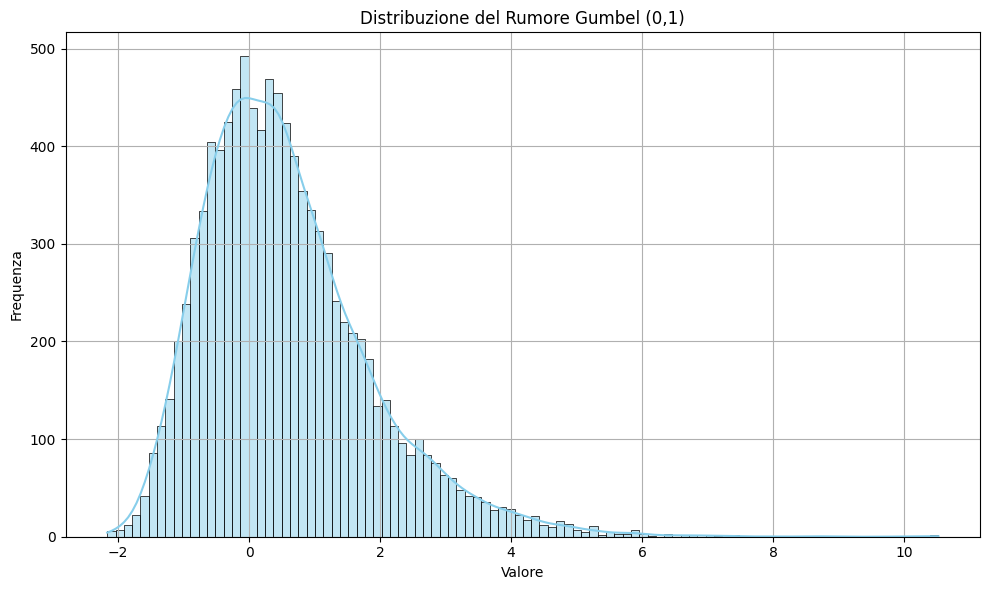

In [ ]:
#ESEMPIO PRATICO DELLA DISTRIBUZIONE GUMBEL"

import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per generare rumore Gumbel
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

# Genera 10.000 campioni dalla distribuzione Gumbel
samples = sample_gumbel((10000,)).numpy()

# Plot della distribuzione
plt.figure(figsize=(10, 6))
sns.histplot(samples, bins=100, kde=True, color='skyblue')
plt.title("Distribuzione del Rumore Gumbel (0,1)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.grid(True)
plt.tight_layout()
plt.show()


#    SECONDO PARTE DEL PIE' DI PAGINA 1: GUMBEL-TEMPERATURE

In [ ]:
# # Gumbel-Softmax con temperatura
# def gumbel_softmax_sample(logits, temperature):
#     gumbel_noise = sample_gumbel(logits.shape)
#     y = logits + gumbel_noise
#     return F.softmax(y / temperature, dim=0)

    Ripetiamo il discroso di prima:

Questa funzione serve a calcolare una versione "casuale ma addestrabile" di una scelta tra opzioni discrete, usando la Gumbel-Softmax. È un’alternativa al argmax, che però funziona bene durante il training di reti neurali (perché è differenziabile).


#############


**def gumbel_softmax_sample(logits, temperature):**
-   “gumbel_softmax_sample": è il nome della funzione. Vuol dire "calcola un campione usando la Gumbel-Softmax".
-   "logits": I logits sono i valori grezzi prodotti da un modello neurale prima di essere trasformati in probabilità.Sono l’output finale di una rete neurale, prima di applicare softmax o sigmoid.
-   "temperature": è un parametro che controlla quanto la scelta è netta (valore basso, 0.1) o morbida (valore alto, 2.0)


#############


**gumbel_noise = sample_gumbel(logits.shape)**
-   “Chiama la funzione sample_gumbel(...)" (che abbiamo spiegato prima) per generare rumore Gumbel
-   "Gli passa logits.shape", così che il rumore abbia esattamente la stessa forma dei logits (cioè 1 valore per ogni classe/azione).
-   Il risultato è un tensor (matrice multidimensionale) di numeri casuali, distribuiti secondo la distribuzione Gumbel.


#############


**y = logits + gumbel_noise**
-   Somma i punteggi (logits) al rumore Gumbel: Questo è il trucco chiave chiamato **Gumbel-Max Trick**: “Scegli l’elemento con punteggio + rumore più alto.”


#############


**return F.softmax(y / temperature, dim=0)**
-   Applica la softmax ai valori modificati (logits + rumore), divisi per la temperatura.
-   dim=0: significa che la softmax è applicata sul primo asse (cioè lungo il vettore).
-   temperature: controlla la precisione della scelta.


#############


**ESEMPIO PRATICO**

logits = torch.tensor([2.0, 1.0, 0.1])

Senza rumore → softmax(logits) = [0.71, 0.26, 0.03]

Con Gumbel noise + temperatura bassa → risultato ≈ [1.0, 0.0, 0.0]

Con temperatura alta → risultato ≈ [0.4, 0.3, 0.3]


    gumbel_softmax_sample è come un argmax intelligente e morbido: fa scelte random, ma impara mentre lo fa
    
    Il rumore Gumbel non distrugge l'informazione:
    la "mescola" per dare una possibilità a ogni scelta, ma in modo che le più forti vincano più spesso.

#    PRIMA PARTE NON PRESENTE NEL SPIEGAZIONE.PY 
#   (parte aggiuntiva per la compresione)


In [ ]:
# # Logits simulati
# logits = torch.tensor([2.0, 1.0, 0.1])
# labels = ['Classe 1', 'Classe 2', 'Classe 3']
# x = np.arange(len(labels))

# # Softmax
# softmax_out = F.softmax(logits, dim=0)

# # Argmax
# argmax_index = torch.argmax(logits)
# argmax_out = torch.zeros_like(logits)
# argmax_out[argmax_index] = 1.0

# # Gumbel-Softmax con temperature diverse
# temperatures = [2.0, 1.0, 0.5, 0.1]
# gumbel_outs = [gumbel_softmax_sample(logits, t) for t in temperatures]


**logits = torch.tensor([2.0, 1.0, 0.1])**:
-    Crea un tensor 1D con 3 valori.
-   Questi rappresentano i punteggi grezzi associati a tre classi. Più è alto il numero, più “forte” è quella classe (prima del softmax).
-   Questi non sono ancora probabilità, ma logits — punteggi da convertire in probabilità.


#############


**labels = ['Classe 1', 'Classe 2', 'Classe 3']**
-   Crea una lista con i nomi delle classi, utile per etichettare i grafici.


#############


**x = np.arange(len(labels))**:
-   Crea un array [0, 1, 2] per l'asse X del grafico.
-   Serve per posizionare le barre (Classe 1 → posizione 0, Classe 2 → posizione 1, ecc.).


#############


**softmax_out = F.softmax(logits, dim=0)**
-   Applica la funzione softmax ai logits.
-   dim=0: significa che la softmax è calcolata lungo l’asse delle righe (vettore verticale).
-   Trasforma i logits in probabilità normalizzate che sommano a 1.

    esempio: La classe 1 ha la probabilità più alta, ma anche le altre hanno un peso.
logits = [2.0, 1.0, 0.1]
softmax_out ≈ [0.659, 0.242, 0.099]


#############


**argmax_index = torch.argmax(logits)*+
-   Trova l'indice del valore più alto tra i logits.
-   Qui: argmax_index = 0 (perché 2.0 è il più alto, guardando il piccolo esempio appena scritto).


#############


**argmax_out = torch.zeros_like(logits)**
-    Crea un tensor di zeri, della stessa forma di logits.
-   Inizializza il risultato come se nessuna classe fosse scelta.


#############


**argmax_out[argmax_index] = 1.0**
-   Imposta il valore a 1.0 nell’indice trovato prima.
-   Risultato: argmax_out = [1.0, 0.0, 0.0] → scelta netta, come un one-hot vector.


#############


**temperatures = [2.0, 1.0, 0.5, 0.1]**
-   Lista di temperature da usare per testare la Gumbel-Softmax.
-   La temperatura controlla la "nitidezza" della scelta: alta - simile alla softmax    |  bassa - simile alla argmax


#############


**gumbel_outs = [gumbel_softmax_sample(logits, t) for t in temperatures]**
-   Usa una list comprehension per applicare la funzione gumbel_softmax_sample ai logits con ogni valore di temperatura t.
-   Crea una lista di 4 vettori: Uno per ogni temperatura - Ogni vettore ha una distribuzione casuale ma guidata dai logits




`Hai 3 modi diversi per rappresentare una scelta:`

| Metodo           | Output                        | Comportamento                             |
| ---------------- | ----------------------------- | ----------------------------------------- |
| `softmax`        | \[0.65, 0.24, 0.11]           | Scelta **liscia**                         |
| `argmax`         | \[1.0, 0.0, 0.0]              | Scelta **dura** (netta)                   |
| `gumbel_softmax` | \[0.98, 0.01, 0.01] (esempio) | Scelta **quasi netta**, ma **derivabile** |


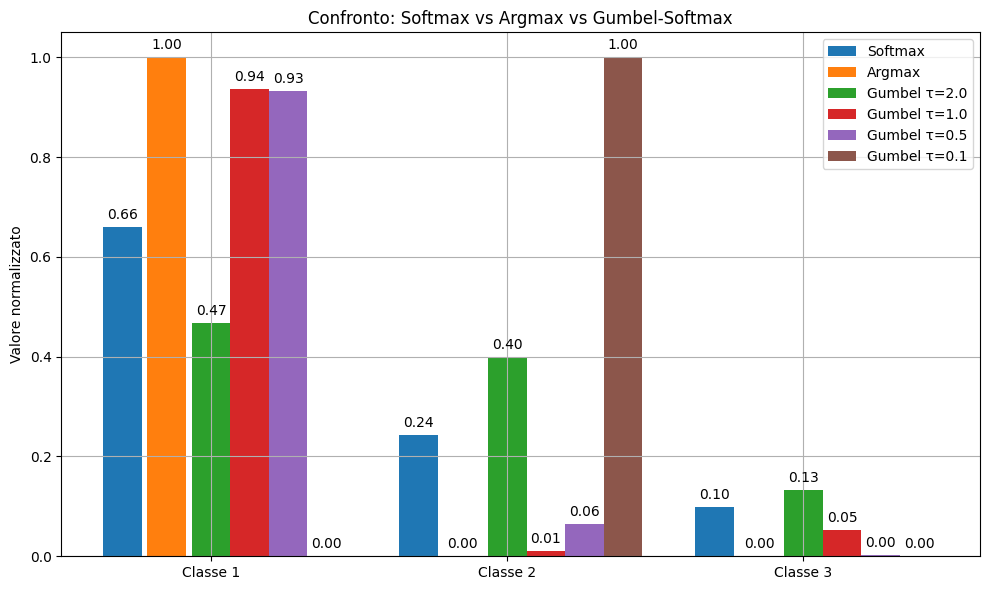

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Funzione per generare rumore Gumbel
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


# Gumbel-Softmax con temperatura
def gumbel_softmax_sample(logits, temperature):
    gumbel_noise = sample_gumbel(logits.shape)
    y = logits + gumbel_noise
    return F.softmax(y / temperature, dim=0)v

######################################################
#le righe precedenti sono dal spiegazione.py E sono state spiegate in dettaglio sopra

# Logits simulati
logits = torch.tensor([2.0, 1.0, 0.1])
labels = ['Classe 1', 'Classe 2', 'Classe 3']
x = np.arange(len(labels))

# Softmax
softmax_out = F.softmax(logits, dim=0)

# Argmax
argmax_index = torch.argmax(logits)
argmax_out = torch.zeros_like(logits)
argmax_out[argmax_index] = 1.0

# Gumbel-Softmax con temperature diverse
temperatures = [2.0, 1.0, 0.5, 0.1]
gumbel_outs = [gumbel_softmax_sample(logits, t) for t in temperatures]

######################################################
#Le righe precedenti sono state speigate sopra
# Plot
bar_width = 0.13
plt.figure(figsize=(10, 6))

# Softmax
offset_softmax = -0.3
bars = plt.bar(x + offset_softmax, softmax_out.numpy(), width=bar_width, label='Softmax')
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Argmax
offset_argmax = -0.15
bars = plt.bar(x + offset_argmax, argmax_out.numpy(), width=bar_width, label='Argmax')
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Gumbel-Softmax
for i, temp in enumerate(temperatures):
    offset = i * bar_width
    values = gumbel_outs[i].numpy()
    bars = plt.bar(x + offset, values, width=bar_width, label=f'Gumbel τ={temp}')
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xticks(x, labels)
plt.title('Confronto: Softmax vs Argmax vs Gumbel-Softmax')
plt.ylabel('Valore normalizzato')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ✅ Interpretazione del grafico

- **Softmax** distribuisce le probabilità in modo continuo e proporzionale ai logits.
- **Argmax** restituisce una selezione netta (una sola classe ha valore 1).
- **Gumbel-Softmax** fa una selezione "soft" che imita argmax ma resta derivabile:
  - Con **temperatura alta**, la scelta è distribuita.
  - Con **temperatura bassa**, la scelta è molto netta.

Perfetta per **addestrare modelli neurali che devono selezionare feature in modo discreto**.